### 통계 기반 기법 vs. 추론 기반 기법   

In [1]:
import sys
sys.path.append('C:/Users/KimDongyoung/Desktop/Github/my_git/mygit/DEEPLEARNING/밑바닥부터시작하는딥러닝2')
import numpy as np
# from common.util import most_similar, create_co_matrix, ppmi
from ptb import load_data

In [2]:
def cos_similarity(x, y, eps=1e-8):
    '''코사인 유사도 산출

    :param x: 벡터
    :param y: 벡터
    :param eps: '0으로 나누기'를 방지하기 위한 작은 값
    :return:
    '''
    nx = x / (np.sqrt(np.sum(x ** 2)) + eps)
    ny = y / (np.sqrt(np.sum(y ** 2)) + eps)
    return np.dot(nx, ny)


def most_similar(query, word_to_id, id_to_word, word_matrix, top=5):
    '''유사 단어 검색

    :param query: 쿼리(텍스트)
    :param word_to_id: 단어에서 단어 ID로 변환하는 딕셔너리
    :param id_to_word: 단어 ID에서 단어로 변환하는 딕셔너리
    :param word_matrix: 단어 벡터를 정리한 행렬. 각 행에 해당 단어 벡터가 저장되어 있다고 가정한다.
    :param top: 상위 몇 개까지 출력할 지 지정
    '''
    if query not in word_to_id:
        print('%s(을)를 찾을 수 없습니다.' % query)
        return

    print('\n[query] ' + query)
    query_id = word_to_id[query]
    query_vec = word_matrix[query_id]

    # 코사인 유사도 계산
    vocab_size = len(id_to_word)

    similarity = np.zeros(vocab_size)
    for i in range(vocab_size):
        similarity[i] = cos_similarity(word_matrix[i], query_vec)

    # 코사인 유사도를 기준으로 내림차순으로 출력
    count = 0
    for i in (-1 * similarity).argsort():
        if id_to_word[i] == query:
            continue
        print(' %s: %s' % (id_to_word[i], similarity[i]))

        count += 1
        if count >= top:
            return

def create_co_matrix(corpus, vocab_size, window_size=1):
    '''동시발생 행렬 생성

    :param corpus: 말뭉치(단어 ID 목록)
    :param vocab_size: 어휘 수
    :param window_size: 윈도우 크기(윈도우 크기가 1이면 타깃 단어 좌우 한 단어씩이 맥락에 포함)
    :return: 동시발생 행렬
    '''
    corpus_size = len(corpus)
    co_matrix = np.zeros((vocab_size, vocab_size), dtype=np.int32)

    for idx, word_id in enumerate(corpus):
        for i in range(1, window_size + 1):
            left_idx = idx - i
            right_idx = idx + i

            if left_idx >= 0:
                left_word_id = corpus[left_idx]
                co_matrix[word_id, left_word_id] += 1

            if right_idx < corpus_size:
                right_word_id = corpus[right_idx]
                co_matrix[word_id, right_word_id] += 1

    return co_matrix
  
def ppmi(C, verbose=False, eps = 1e-8):
    '''PPMI(점별 상호정보량) 생성

    :param C: 동시발생 행렬
    :param verbose: 진행 상황을 출력할지 여부
    :return:
    '''
    M = np.zeros_like(C, dtype=np.float32)
    N = np.sum(C)
    S = np.sum(C, axis=0)
    total = C.shape[0] * C.shape[1]
    cnt = 0

    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
            pmi = np.log2(C[i, j] * N / (S[j]*S[i]) + eps)
            M[i, j] = max(0, pmi)

            if verbose:
                cnt += 1
                if cnt % (total//100 + 1) == 0:
                    print('%.1f%% 완료' % (100*cnt/total))
    return M

def normalize(x):
    if x.ndim == 2:
        s = np.sqrt((x * x).sum(1))
        x /= s.reshape((s.shape[0], 1))
    elif x.ndim == 1:
        s = np.sqrt((x * x).sum())
        x /= s
    return x


def analogy(a, b, c, word_to_id, id_to_word, word_matrix, top=5, answer=None):
    for word in (a, b, c):
        if word not in word_to_id:
            print('%s(을)를 찾을 수 없습니다.' % word)
            return

    print('\n[analogy] ' + a + ':' + b + ' = ' + c + ':?')
    a_vec, b_vec, c_vec = word_matrix[word_to_id[a]], word_matrix[word_to_id[b]], word_matrix[word_to_id[c]]
    query_vec = b_vec - a_vec + c_vec           # (b - a) + c   (b-a)는 a에서 b로 가는 벡터이다. 그래서 이 벡터에 c를 더하면 c에서 어디로 가는 벡터가 나온다.
    query_vec = normalize(query_vec)

    similarity = np.dot(word_matrix, query_vec)

    if answer is not None:
        print("==>" + answer + ":" + str(np.dot(word_matrix[word_to_id[answer]], query_vec)))

    count = 0
    for i in (-1 * similarity).argsort():
        if np.isnan(similarity[i]):
            continue
        if id_to_word[i] in (a, b, c):
            continue
        print(' {0}: {1}'.format(id_to_word[i], similarity[i]))

        count += 1
        if count >= top:
            return

In [10]:
window_size = 2
wordvec_size = 100

corpus, word_to_id, id_to_word = load_data('train')
vocab_size = len(word_to_id)
print('동시발생 수 계산 ...')
C = create_co_matrix(corpus, vocab_size, window_size)
print('PPMI 계산 ...')
W = ppmi(C, verbose=True)

print('calculating SVD ...')
try:
    # truncated SVD (빠르다!)
    from sklearn.utils.extmath import randomized_svd
    U, S, V = randomized_svd(W, n_components=wordvec_size, n_iter=5,
                             random_state=None)
except ImportError:
    # SVD (느리다)
    U, S, V = np.linalg.svd(W)

word_vecs = U[:, :wordvec_size]

querys = ['you', 'year', 'car', 'toyota']
for query in querys:
    most_similar(query, word_to_id, id_to_word, word_vecs, top=5)

동시발생 수 계산 ...
PPMI 계산 ...


C:\Users\KimDongyoung\AppData\Local\Temp\ipykernel_6196\311581501.py:90: RuntimeWarning: overflow encountered in scalar multiply
  pmi = np.log2(C[i, j] * N / (S[j]*S[i]) + eps)
C:\Users\KimDongyoung\AppData\Local\Temp\ipykernel_6196\311581501.py:90: RuntimeWarning: invalid value encountered in log2
  pmi = np.log2(C[i, j] * N / (S[j]*S[i]) + eps)


1.0% 완료
2.0% 완료
3.0% 완료
4.0% 완료
5.0% 완료
6.0% 완료
7.0% 완료
8.0% 완료
9.0% 완료
10.0% 완료
11.0% 완료
12.0% 완료
13.0% 완료
14.0% 완료
15.0% 완료
16.0% 완료
17.0% 완료
18.0% 완료
19.0% 완료
20.0% 완료
21.0% 완료
22.0% 완료
23.0% 완료
24.0% 완료
25.0% 완료
26.0% 완료
27.0% 완료
28.0% 완료
29.0% 완료
30.0% 완료
31.0% 완료
32.0% 완료
33.0% 완료
34.0% 완료
35.0% 완료
36.0% 완료
37.0% 완료
38.0% 완료
39.0% 완료
40.0% 완료
41.0% 완료
42.0% 완료
43.0% 완료
44.0% 완료
45.0% 완료
46.0% 완료
47.0% 완료
48.0% 완료
49.0% 완료
50.0% 완료
51.0% 완료
52.0% 완료
53.0% 완료
54.0% 완료
55.0% 완료
56.0% 완료
57.0% 완료
58.0% 완료
59.0% 완료
60.0% 완료
61.0% 완료
62.0% 완료
63.0% 완료
64.0% 완료
65.0% 완료
66.0% 완료
67.0% 완료
68.0% 완료
69.0% 완료
70.0% 완료
71.0% 완료
72.0% 완료
73.0% 완료
74.0% 완료
75.0% 완료
76.0% 완료
77.0% 완료
78.0% 완료
79.0% 완료
80.0% 완료
81.0% 완료
82.0% 완료
83.0% 완료
84.0% 완료
85.0% 완료
86.0% 완료
87.0% 완료
88.0% 완료
89.0% 완료
90.0% 완료
91.0% 완료
92.0% 완료
93.0% 완료
94.0% 완료
95.0% 완료
96.0% 완료
97.0% 완료
98.0% 완료
99.0% 완료
calculating SVD ...

[query] you
 i: 0.6971861720085144
 we: 0.6577469706535339
 anybody: 0.5785029530525208
 do: 0.55

### 통계 기반 기법 평가  

In [11]:
# 유추(analogy) 작업
print('-'*50)
print("통계 기반 기법 결과")
analogy('king', 'man', 'queen',  word_to_id, id_to_word, word_vecs)
analogy('take', 'took', 'go',  word_to_id, id_to_word, word_vecs)
analogy('car', 'cars', 'child',  word_to_id, id_to_word, word_vecs)
analogy('good', 'better', 'bad',  word_to_id, id_to_word, word_vecs)
analogy('dog', 'kennel', 'bird',  word_to_id, id_to_word, word_vecs)
analogy('teacher', 'school', 'doctor',  word_to_id, id_to_word, word_vecs)
analogy('ear', 'hear', 'eye',  word_to_id, id_to_word, word_vecs)
analogy('leg', 'walk', 'hand',  word_to_id, id_to_word, word_vecs)
analogy('leg', 'legs', 'hand',  word_to_id, id_to_word, word_vecs)

--------------------------------------------------

[analogy] king:man = queen:?
 who: 0.11196982860565186
 she: 0.09461738169193268
 among: 0.07201318442821503
 ': 0.07159817218780518
 young: 0.06765370815992355

[analogy] take:took = go:?
 says: 0.10150566697120667
 into: 0.08729947358369827
 mr.: 0.07824079692363739
 went: 0.07464049011468887
 back: 0.07279105484485626

[analogy] car:cars = child:?
 than: 0.11771439015865326
 more: 0.11327702552080154
 where: 0.09139949828386307
 an: 0.09116490185260773
 inc.: 0.08456432819366455

[analogy] good:better = bad:?
 more: 0.1075090765953064
 than: 0.10305674374103546
 often: 0.09605096280574799
 whose: 0.07297506928443909
 those: 0.06851065158843994


### 추론 기반 기법    

In [3]:
from common import config
# GPU에서 실행하려면 아래 주석을 해제하세요(CuPy 필요).
# ===============================================
# config.GPU = True
# ===============================================
import pickle
from common.trainer import Trainer
from common.optimizer import Adam
from ch04.cbow import CBOW
from common.util import create_contexts_target, to_cpu, to_gpu
from ptb import load_data

| 에폭 1 |  반복 1 / 9295 | 시간 0[s] | 손실 4.16
| 에폭 1 |  반복 21 / 9295 | 시간 1[s] | 손실 4.16
| 에폭 1 |  반복 41 / 9295 | 시간 2[s] | 손실 4.16
| 에폭 1 |  반복 61 / 9295 | 시간 3[s] | 손실 4.14
| 에폭 1 |  반복 81 / 9295 | 시간 4[s] | 손실 4.10
| 에폭 1 |  반복 101 / 9295 | 시간 6[s] | 손실 4.02
| 에폭 1 |  반복 121 / 9295 | 시간 7[s] | 손실 3.90
| 에폭 1 |  반복 141 / 9295 | 시간 8[s] | 손실 3.77
| 에폭 1 |  반복 161 / 9295 | 시간 9[s] | 손실 3.63
| 에폭 1 |  반복 181 / 9295 | 시간 10[s] | 손실 3.51
| 에폭 1 |  반복 201 / 9295 | 시간 11[s] | 손실 3.40
| 에폭 1 |  반복 221 / 9295 | 시간 12[s] | 손실 3.31
| 에폭 1 |  반복 241 / 9295 | 시간 14[s] | 손실 3.22
| 에폭 1 |  반복 261 / 9295 | 시간 15[s] | 손실 3.14
| 에폭 1 |  반복 281 / 9295 | 시간 16[s] | 손실 3.10
| 에폭 1 |  반복 301 / 9295 | 시간 17[s] | 손실 3.04
| 에폭 1 |  반복 321 / 9295 | 시간 18[s] | 손실 2.98
| 에폭 1 |  반복 341 / 9295 | 시간 20[s] | 손실 2.95
| 에폭 1 |  반복 361 / 9295 | 시간 21[s] | 손실 2.91
| 에폭 1 |  반복 381 / 9295 | 시간 22[s] | 손실 2.88
| 에폭 1 |  반복 401 / 9295 | 시간 23[s] | 손실 2.85
| 에폭 1 |  반복 421 / 9295 | 시간 25[s] | 손실 2.82
| 에폭 1 |  반복 441 / 9295 |

c:\Users\KimDongyoung\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 48152 (\N{HANGUL SYLLABLE BAN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\KimDongyoung\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 48373 (\N{HANGUL SYLLABLE BOG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\KimDongyoung\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 49552 (\N{HANGUL SYLLABLE SON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\KimDongyoung\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


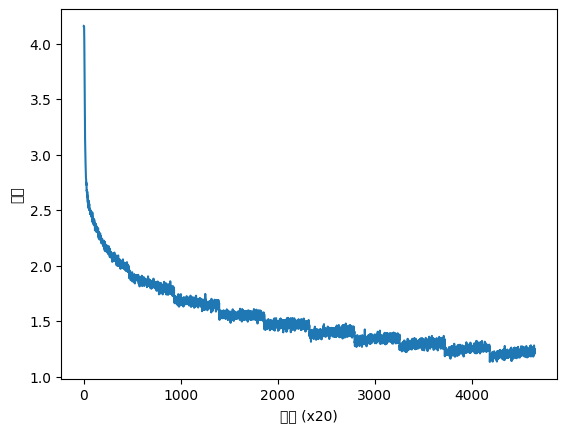

In [4]:
# 하이퍼파라미터 설정
window_size = 2
hidden_size = 100
batch_size = 100
max_epoch = 10

# 데이터 읽기
corpus, word_to_id, id_to_word = load_data('train')
vocab_size = len(word_to_id)

contexts, target = create_contexts_target(corpus, window_size)
if config.GPU:
    contexts, target = to_gpu(contexts), to_gpu(target)

# 모델 등 생성
model = CBOW(vocab_size, hidden_size, window_size, corpus)
optimizer = Adam()
trainer = Trainer(model, optimizer)

# 학습 시작
trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

# 나중에 사용할 수 있도록 필요한 데이터 저장
word_vecs = model.word_vecs
if config.GPU:
    word_vecs = to_cpu(word_vecs)
params = {}
params['word_vecs'] = word_vecs.astype(np.float16)
params['word_to_id'] = word_to_id
params['id_to_word'] = id_to_word
pkl_file = 'cbow_params.pkl'  # or 'skipgram_params.pkl'
with open(pkl_file, 'wb') as f:
    pickle.dump(params, f, -1)

In [6]:
# 유추(analogy) 작업
print('-'*50)
print("추론 기반 기법 결과")
analogy('king', 'man', 'queen',  word_to_id, id_to_word, word_vecs)
analogy('take', 'took', 'go',  word_to_id, id_to_word, word_vecs)
analogy('car', 'cars', 'child',  word_to_id, id_to_word, word_vecs)
analogy('good', 'better', 'bad',  word_to_id, id_to_word, word_vecs)

--------------------------------------------------
추론 기반 기법 결과

[analogy] king:man = queen:?
 reason: 4.16910982131958
 thing: 3.5434231758117676
 respect: 3.3454971313476562
 woman: 3.197848081588745
 decade: 3.1147024631500244

[analogy] take:took = go:?
 ended: 3.5958752632141113
 went: 3.234353542327881
 lived: 3.114945888519287
 goes: 3.0501818656921387
 east: 2.9858169555664062

[analogy] car:cars = child:?
 cubic: 3.42816162109375
 duties: 3.27427077293396
 homes: 3.2662317752838135
 rape: 3.264554262161255
 children: 3.2632460594177246

[analogy] good:better = bad:?
 greater: 3.6844727993011475
 less: 3.508070707321167
 n't: 3.4903883934020996
 outweigh: 2.9878413677215576
 more: 2.9800236225128174
